In [1]:
# installing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install praat-parselmouth
import parselmouth
from itertools import chain
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 21.2 MB/s eta 0:00:00


The folder 'Audio_Dataset' contains all data samples. They are then separated into folders titled 'Actor_XX', where XX denotes
the actor's ID (1 - 24). Each of these folders contains 60 .wav files corresponding to the actor, and the titles of the audio files give more information.

In [2]:
# reading all file names to extract raw features
from google.colab import drive
drive.mount('/content/drive')

directory_files = []

for i in range(1,10):
  directory_path = '/content/drive/MyDrive/ML_F24_Team_Project/Dataset1/Audio_Dataset/Actor_0'+str(i)
  for j in os.listdir(directory_path):
    directory_files.append(j)

for i in range(10,25):
  directory_path = '/content/drive/MyDrive/ML_F24_Team_Project/Dataset1/Audio_Dataset/Actor_'+str(i)
  for j in os.listdir(directory_path):
    directory_files.append(j)

Mounted at /content/drive


In [3]:
# making lists corresponding to each feature, to then turn raw into a dataframe
# gender is stored as a boolean, with female = 0, and male = 1
modality, vocal_channel, emotion, intensity, statement, repetition, gender, actorID = [], [], [], [], [], [], [],[]

for x in directory_files:
  actorID.append(int(x.split('-')[6].split('.')[0]))
  modality.append(x.split('-')[0])
  vocal_channel.append(x.split('-')[1])
  emotion.append(x.split('-')[2])
  intensity.append(x.split('-')[3])
  statement.append(x.split('-')[4])
  repetition.append(x.split('-')[5])
  gender.append(bool(int(x.split('-')[6].split('.')[0])%2))

In [4]:
audio_df = pd.DataFrame()
audio_df['actorID'] = actorID
audio_df['modality'] = modality
audio_df['vocal_channel'] = vocal_channel
audio_df['emotion'] = emotion
audio_df['emotional_intensity'] = intensity
audio_df['statement'] = statement
audio_df['repetition'] = repetition
audio_df['gender'] = gender

# (a) Brief Exploration of Dataset

In [ ]:
# Number of samples
num_samples = audio_df.shape[0]
print('The number of samples is ', num_samples)

The number of samples is  1440


In [ ]:
# Number of raw features
num_features = audio_df.shape[1]
print('The number of raw features is ', num_features+1,':',audio_df.columns.values,'and the audio file')

The number of raw features is  8 : ['modality' 'vocal_channel' 'emotion' 'emotional_intensity' 'statement'
 'repetition' 'gender'] and the audio file


In [ ]:
# Fraction of missing values (if any)
print(audio_df.isna().stack().unique())

[False]


By looking for NaN values in the dataset, we see none. Therefore, there are no missing values, and all other numbers have a valid values in within their categories.

In [ ]:
# Number of categorical variables
for x in audio_df.columns.values:
  print(x,':',audio_df[x].unique())

modality : ['03']
vocal_channel : ['01']
emotion : ['01' '02' '03' '04' '05' '06' '07' '08']
emotional_intensity : ['01' '02']
statement : ['01' '02']
repetition : ['01' '02']
gender : [ True False]


[5]
All of these variables are categorical, except for the audio file itself, so there are 7 categorical variables.

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Gender (False = female, True = Male).

All these categorical variables have already been encoding, whether through label encoding (Modality, Vocal channel, Emotion, Statement), Ordinal Encoding (Emotional intensity, repitition), or binary encoding (Gender).

Notes for later feature extraction:
- There is only one modality, audio, and one vocal channel, speech, so it is unnecessary to include these variables.
- Our task will be to classify audio files based on their emotion, making emotion the target variable. Since all the samples are labeled, it is a supervised task.  

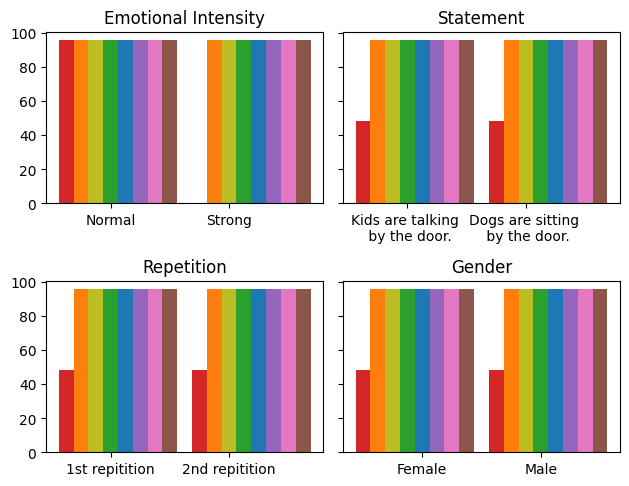

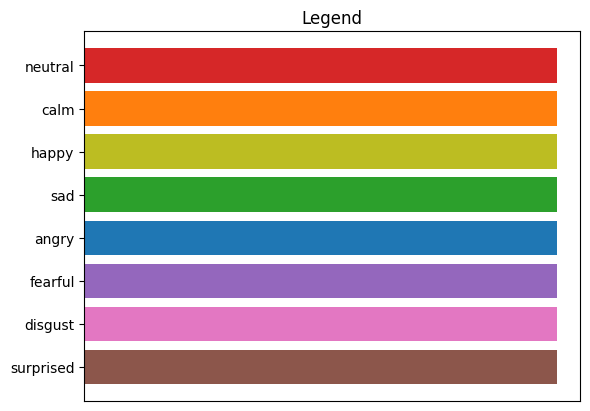

In [ ]:
#returns number of samples where the label is emotion and value of variable is variable
def bar_height(emotion, variable, variable_value):
  return len(audio_df[(audio_df['emotion'] == emotion) & (audio_df[variable] == variable_value)])

variables = ["Emotional Intensity", "Statement", "Repetition","Gender"]

emotions = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
em_encode = ['01','02','03','04','05','06','07','08']
bar_labels = ['red', 'orange', 'brown', 'green','blue','purple','pink','brown', 'gray']
bar_colors = ['tab:red', 'tab:orange', 'tab:olive', 'tab:green','tab:blue','tab:purple','tab:pink','tab:brown']

fig, ax = plt.subplots(2,2,sharey=True,tight_layout=True)

for j in (audio_df['emotional_intensity'].unique()):
  for i in range(len(em_encode)):
    x = em_encode[i]
    y = bar_labels[i]
    z = bar_colors[i]
    ax[0,0].bar(9*int(j)+i, bar_height(x, 'emotional_intensity', j), width = 1, label = y, color = z)
  #ax[0].get_xaxis().set_visible(False)
  ax[0,0].set_title(variables[0])

for j in (audio_df['statement'].unique()):
  for i in range(len(em_encode)):
    x = em_encode[i]
    y = bar_labels[i]
    z = bar_colors[i]
    ax[0,1].bar(9*int(j)+i, bar_height(x, 'statement', j), width = 1, label = y, color = z)
  ax[0,1].set_title(variables[1])

for j in (audio_df['repetition'].unique()):
  for i in range(len(em_encode)):
    x = em_encode[i]
    y = bar_labels[i]
    z = bar_colors[i]
    ax[1,0].bar(9*int(j)+i, bar_height(x, 'repetition', j), width = 1, label = y, color = z)
  ax[1,0].set_title(variables[2])
box = ax[1,0].get_position()
ax[1,0].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

for j in (audio_df['gender'].unique()):
  for i in range(len(em_encode)):
    x = em_encode[i]
    y = bar_labels[i]
    z = bar_colors[i]
    ax[1,1].bar(9*int(j)+i, bar_height(x, 'gender', j), width = 1, label = y, color = z)
  ax[1,1].set_title(variables[3])
box = ax[1,1].get_position()
ax[1,1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

x = np.array([12,20])
my_xticks = ['Normal','Strong']
ax[0,0].set_xticks(x,my_xticks)

x = np.array([12,20])
my_xticks = ['Kids are talking \n by the door.','Dogs are sitting \n by the door.']
ax[0,1].set_xticks(x,my_xticks)

x = np.array([12,20])
my_xticks = ['1st repitition','2nd repitition']
ax[1,0].set_xticks(x,my_xticks)

x = np.array([4,12])
my_xticks = ['Female','Male']
ax[1,1].set_xticks(x,my_xticks)

plt.show()


fig, legend = plt.subplots()
y_pos = np.arange(len(emotions))
performance = [2]*len(emotions)

legend.barh(y_pos, performance, color=bar_colors, align='center')
legend.set_yticks(y_pos, labels=emotions)
legend.invert_yaxis()  # labels read top-to-bottom
legend.set_title('Legend')
legend.get_xaxis().set_visible(False)

plt.show()

The dataset is evenly divided in almost every feature. There is the same amount of data samples for normal and strong, except for the neutral emotion, which only contains normal samples. There is the same amount of data samples for each of the two statements, same amount of each repitition, and same amount of both genders. Most importantly, there is the same amount of data samples for every emotion (except neutral), making the prior probabilities for each emotion equal (except neutral).

# (b) Pre-Processing

When preprocessing audio files, it is usually the standard to set all the files to the same sample rate and bit depth. However, all samples given are 16-bit and 48kHZ .wav files, so this can be skipped. (The sample rate refers to how many samples compose one second of audio. The bit depth refers to the number of volumes the audio file can take on. A higher bit depth indicates more range in dynamics.)  [3]

Another thing that helps to reduce the amount of data and improve efficiency is trimming the leading and trailing silence.

I will also normalize the amplitude by making it so that all the audio samples have a maximum value of 1 and a minimum value of -1. Machine Learning models can be sensitive to big differences in scale, and how far the speaker is from the microphone will certainly impact the raw audio file's amplitude. A new sample could be recorded from closer or further away from the training set's samples, making the volume softer or louder, and I don't want this to impact the result.

In [5]:
def preprocess_audio(file_path):
    # Load the audio file
    snd = parselmouth.Sound(file_path)

    # Trim silence
    intensity = snd.to_intensity()
    time_stamps = np.array(intensity.xs())  # Time points for intensity
    intensity_values = np.array(intensity.values.T).flatten()  # Intensity values

    # Mask for regions above silence threshold
    silence_threshold=np.max(intensity_values) - 20
    # discard audio parts less than 20 decibals under the maximum intensity, since most conversations fall within the 20 dB range during consistent emotion
    # (neutral conversation, shouting, whispering)
    voiced_mask = intensity_values > silence_threshold
    if not np.any(voiced_mask):
        raise ValueError("No voiced regions found above the silence threshold.")

    # Get the first and last non-silent timestamps
    start_time = time_stamps[voiced_mask.argmax()]
    end_time = time_stamps[len(voiced_mask) - voiced_mask[::-1].argmax() - 1]
    trimmed_snd = snd.extract_part(from_time=start_time, to_time=end_time, preserve_times=True)

    # Normalize amplitude to [-1, 1]
    max_amplitude = np.max(np.abs(trimmed_snd.values))
    if max_amplitude > 0:
        normalized_values = trimmed_snd.values / max_amplitude
    else:
        raise ValueError("Audio is silent after trimming; cannot normalize.")


    return parselmouth.Sound(normalized_values, sampling_frequency=trimmed_snd.sampling_frequency)

# (c) Feature Extraction/Feature Learning

In [ ]:
# From the 82 sounds selected, four factors—loudness, sharpness, roughness, and fluctuation strength—were extracted. [1]
# Thus, acoustic features such as the pitch, timing, voice quality, and articulation of the speech signal highly correlate with the underlying emotion.  [2]

Choice of Extracted Features:

- Pitch (average, minimum, maximum, variance, range, voiced percentage) (At first, we tried having only pitch average as a feature, but this did not yield good results, most likely because we needed more features to have more basis in determining an emotion class.)
- Timing (duration of audio file with speaking, divided by number of syllables) (NOTE: Both statements in this dataset have 7 syllables, so for this dataset processing, we will not divide by the number of syllables. However, if the dataset had statements with various amounts of syllables, this is how we would go about it.)
- Loudness (measured in energy)
- Fluctuation Strength (speaking clearly and articulately would produce more fluctuation, while muttering or speaking monotone would not produce much fluctuation)

In [6]:
# compiling all paths to audio files
folders = []
for i in range(1,10):
  directory_path = '/content/drive/MyDrive/ML_F24_Team_Project/Dataset1/Audio_Dataset/Actor_0'+str(i)
  folders.append(directory_path)

for i in range(10,25):
  directory_path = '/content/drive/MyDrive/ML_F24_Team_Project/Dataset1/Audio_Dataset/Actor_'+str(i)
  folders.append(directory_path)

NOTE: None of these extracted features depend on values found from the training data (means, variances, etc), so there is no need to separate training and test data in this case.

##(i) Pitch

The mean modal fundamental vocal frequency for males was 110.15 Hz, with a mean range from 81.95 Hz to 158.50 Hz. The mean modal fundamental vocal frequency for females was 193.10 Hz, with a mean range from 139.05 Hz to 266.10 Hz. [4]

In [ ]:
# WHEN NORMALIZING, TAKE OUT TEST DATA
# printing folders name to see progress, this thing takes 20 minutes to run
pitch_avg = []
pitch_min = []
pitch_max = []
pitch_var = []
pitch_range = []

male_pitch_avg = 110.15
female_pitch_avg = 193.10

for folder in folders:
  print(folder)
  for file_name in os.listdir(folder):
    path = os.path.join(folder, file_name)
    processed = preprocess_audio(path)
    pitch = processed.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_times = pitch.xs()
    # Finding amount of (preprocessed) audio without voice
    valid_pitch_values = pitch_values[~np.isnan(pitch_values)]

    if int(folder[-1])%2 == 1:
      # if actor is male
      pitch_avg.append(np.nanmean(pitch_values) - male_pitch_avg)
      pitch_min_temp = np.nanmin(pitch_values) - male_pitch_avg
      pitch_max_temp = np.nanmax(pitch_values) - male_pitch_avg
      pitch_min.append(pitch_min_temp)
      pitch_max.append(pitch_max_temp)
      # pitch average is already subtracted while calculating variance
      pitch_var.append(np.var(valid_pitch_values))
      pitch_range.append(pitch_max_temp - pitch_min_temp)
    else:
      # actor is female
      pitch_avg.append(np.nanmean(pitch_values) - female_pitch_avg)
      pitch_min_temp = np.nanmin(pitch_values) - female_pitch_avg
      pitch_max_temp = np.nanmax(pitch_values) - female_pitch_avg
      pitch_min.append(pitch_min_temp)
      pitch_max.append(pitch_max_temp)
      # pitch average is already subtracted while calculating variance
      pitch_var.append(np.var(valid_pitch_values))
      pitch_range.append(pitch_max_temp - pitch_min_temp)



audio_df['pitch_avg'] = pitch_avg
audio_df['pitch_min'] = pitch_min
audio_df['pitch_max'] = pitch_max
audio_df['pitch_var'] = pitch_var
audio_df['pitch_range'] = pitch_range

In [ ]:
# Exploring values within these features by finding the min, quartile 1, mean, quartile 3, and max
print(audio_df['pitch_avg'].quantile([0,.25,.5,.75,1]))
print(audio_df['pitch_min'].quantile([0,.25,.5,.75,1]))
print(audio_df['pitch_max'].quantile([0,.25,.5,.75,1]))
print(audio_df['pitch_var'].quantile([0,.25,.5,.75,1]))
print(audio_df['pitch_range'].quantile([0,.25,.5,.75,1]))
print(audio_df['voiced_percentage'].quantile([0,.25,.5,.75,1]))

0.00   -111.543984
0.25    -21.629328
0.50      4.457941
0.75     46.517666
1.00    276.551611
Name: pitch_avg, dtype: float64
0.00   -193.100
0.25   -193.100
0.50   -151.625
0.75   -110.150
1.00   -110.150
Name: pitch_min, dtype: float64
0.00    -10.195659
0.25     76.715394
0.50    155.213083
0.75    301.897213
1.00    489.753038
Name: pitch_max, dtype: float64
0.00      855.454210
0.25     4876.971156
0.50     9216.565338
0.75    14824.719221
1.00    55262.336696
Name: pitch_var, dtype: float64
0.00     99.954341
0.25    234.102305
0.50    323.467169
0.75    474.515310
1.00    599.978844
Name: pitch_range, dtype: float64
0.00    1.0
0.25    1.0
0.50    1.0
0.75    1.0
1.00    1.0
Name: voiced_percentage, dtype: float64


## (ii) Timing

In [8]:
timing = []

for folder in folders:
  for file_name in os.listdir(folder):
    path = os.path.join(folder, file_name)
    processed = preprocess_audio(path)
    timing.append(processed.duration) # 7 syllables in all statements in this dataset

audio_df['timing'] = timing

In [ ]:
# Exploring values within this feature by finding the min, quartile 1, mean, quartile 3, and max
audio_df['timing'].quantile([0,.25,.5,.75,1])

,timing
0.00,0.784021
0.25,1.416000
0.50,1.580010
0.75,1.816000
1.00,3.312021


## (iii) Loudness

In [9]:
energy = []

for folder in folders:
  for file_name in os.listdir(folder):
    path = os.path.join(folder, file_name)
    processed = preprocess_audio(path)
    amplitude_values = processed.values.flatten()
    energy.append(np.sum(amplitude_values ** 2))

audio_df['loudness'] = energy

In [ ]:
# Exploring values within this feature by finding the min, quartile 1, mean, quartile 3, and max
audio_df['loudness'].quantile([0,.25,.5,.75,1])

,loudness
0.00,317.544997
0.25,1345.179418
0.50,1840.173853
0.75,2522.856339
1.00,5884.986769


## (iv) Fluctuation

In [10]:
fluctuation = []

for folder in folders:
  for file_name in os.listdir(folder):
    path = os.path.join(folder, file_name)
    processed = preprocess_audio(path)

    intensity = processed.to_intensity()
    intensity_values = intensity.values.T.flatten()
    times = intensity.xs()

    window_size = 0.1
    step_size = 0.05
    fluc = []
    time_points = []
    for start in np.arange(0, times[-1] - window_size, step_size):
        # Get intensity values in the current window
        window_mask = (times >= start) & (times < start + window_size)
        window_intensity = intensity_values[window_mask]

        # Skip empty windows
        if len(window_intensity) > 0:
            # Compute fluctuation as the variance of intensity
            fluc.append(np.var(window_intensity))
            time_points.append(start + window_size / 2)


    fluctuation.append(np.nanmean(fluc))

audio_df['fluctuation'] = fluctuation

In [ ]:
# Exploring values within this feature by finding the min, quartile 1, mean, quartile 3, and max
audio_df['fluctuation'].quantile([0,.25,.5,.75,1])

,fluctuation
0.00,4.493989
0.25,13.791979
0.50,19.084648
0.75,25.085767
1.00,58.942762


In [ ]:
# taking a peek at our new features
audio_df.loc[::60]

,actorID,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,gender,pitch_avg,pitch_min,pitch_max,pitch_var,pitch_range,timing,loudness,fluctuation
0,1,03,01,01,01,01,01,True,-19.331810,-110.15,47.167736,2163.335610,157.317736,1.208000,1537.727692,22.071465
60,2,03,01,02,02,02,01,False,-27.514442,-193.10,87.133205,10988.576977,280.233205,1.968000,1828.917860,26.150429
120,3,03,01,05,01,01,02,True,-7.098404,-110.15,436.270622,7470.255733,546.420622,1.864021,1347.805428,38.452042
180,4,03,01,02,01,01,02,False,-5.205337,-193.10,147.922072,10929.290912,341.022072,1.696021,4076.616665,21.358355
240,5,03,01,02,01,01,02,True,-45.529831,-110.15,13.893135,2748.630340,124.043135,1.912000,1274.220807,26.149319
300,6,03,01,01,01,01,02,False,11.896993,-193.10,105.083444,5516.291513,298.183444,1.592021,2046.022700,15.539505
360,7,03,01,02,01,02,02,True,-6.364266,-110.15,38.128895,2443.430953,148.278895,1.544000,1698.984848,13.342218
420,8,03,01,02,01,02,01,False,-38.797523,-193.10,75.325454,7120.556781,268.425454,1.472000,2409.249620,9.801757
480,9,03,01,05,02,02,01,True,104.317830,-110.15,483.830997,33301.442534,593.980997,2.312000,2964.816043,24.448951
540,10,03,01,01,01,02,01,False,22.237463,-193.10,99.868612,5904.916853,292.968612,1.672021,4444.377799,13.124034


# (d) Dataset Processing

In [ ]:
# 6 folds, each with 4 actors, ID's are shuffled with equal amounts of male and female actors in each fold
# DO NOT CHANGE

MALES = np.arange(1,24,2)
np.random.shuffle(MALES)
print(MALES)

FEMALES = np.arange(2,25,2)
np.random.shuffle(FEMALES)
print(FEMALES)

[17  7 11 23 13  9  5  1 21 15 19  3]
[14 16 24 20  8 18 22  4 12  2  6 10]


In [11]:
# DO NOT CHANGE
fold1 = [17,7,14,16]
fold2 = [11,23,24,20]
fold3 = [13,9,8,18]
fold4 = [5,1,22,4]
fold5 = [21,15,12,2]
fold6 = [19,3,6,10]

In [12]:
feature_vars = ['pitch_avg','pitch_min','pitch_max','pitch_var','pitch_range','timing','loudness','fluctuation']
target_var = 'emotion'

## (i) Machine Learning Method 1

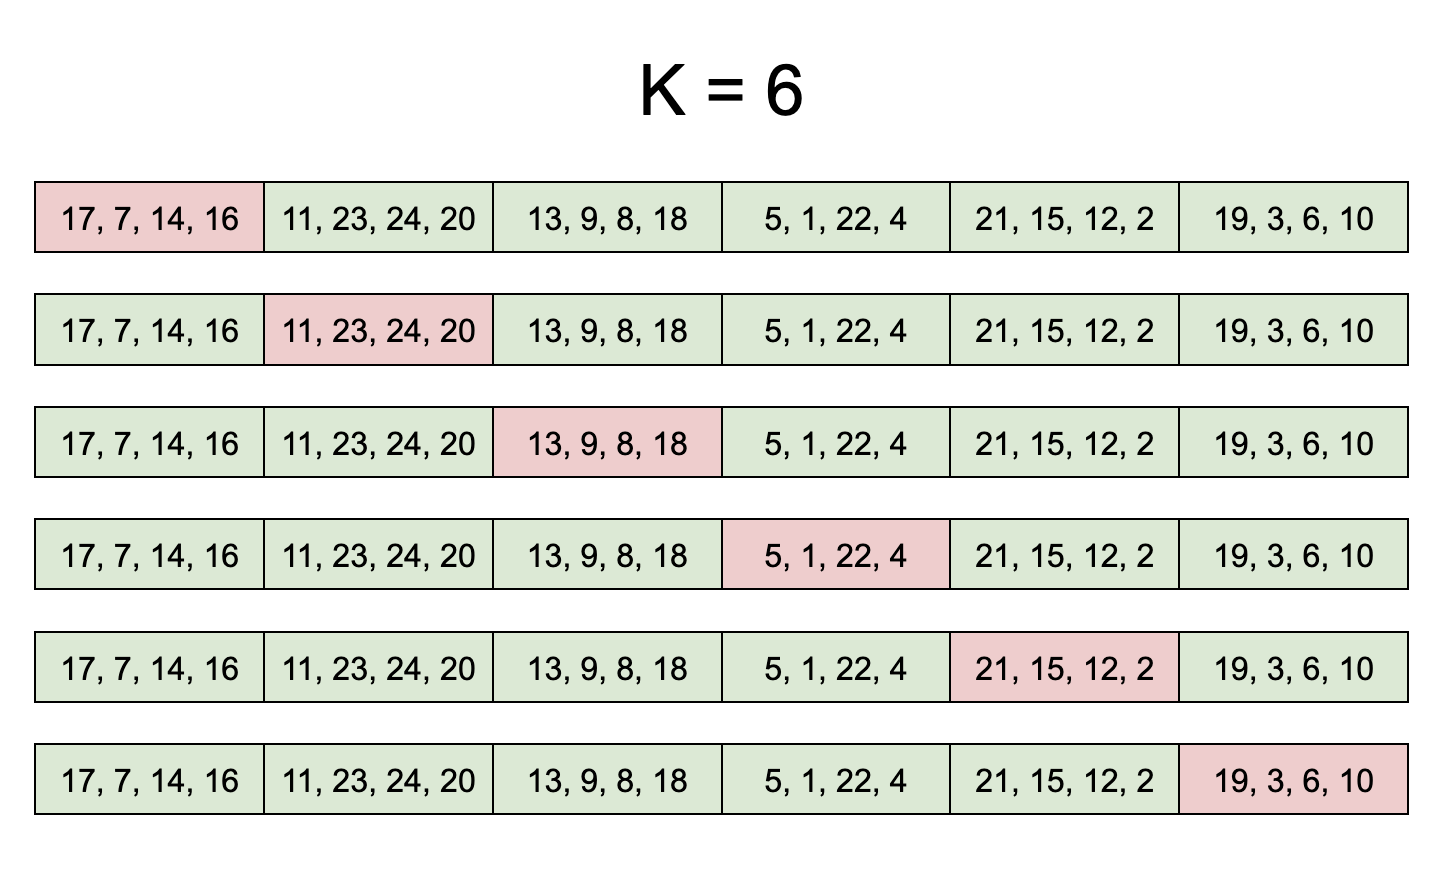

For our first method, we chose Linear Discriminant Analysis, which we will perform K-fold Cross Validation on. The above image presents the train-test splits for each fold. Green represents training folds, Red represents test fold

In [13]:
# takes the training data and returns the parameters it learns
def train_LDA (fold_number):
  test_fold = globals()['fold'+str(fold_number)]

  training_folds = set(chain(fold1, fold2, fold3, fold4, fold5, fold6)) # entire dataset, all 6 folds
  training_folds.difference_update(test_fold) # drop the fold being used for testing


  train = audio_df[audio_df['actorID'].isin(training_folds)]
  x_train = train[feature_vars].copy()
  y_train = train[target_var].astype(int)

  # LDA
  parameters = LinearDiscriminantAnalysis()
  parameters.fit(x_train, y_train)

  return parameters

In [14]:
# takes parameters from the training data and makes a prediction on the test data
def predict_LDA (parameters, fold_number):
  test_fold = globals()['fold'+str(fold_number)]

  test = audio_df[audio_df['actorID'].isin(test_fold)]
  x_test = test[feature_vars].copy()

  y_pred = parameters.predict(x_test)

  return y_pred

In [15]:
# takes the prediction on the test data and compares it with the actual labels
def test_LDA (fold_number):
  test_fold = globals()['fold'+str(fold_number)]
  test = audio_df[audio_df['actorID'].isin(test_fold)]
  y_test = test[target_var].astype(int)

  parameters = train_LDA(fold_number)
  y_pred = predict_LDA(parameters, fold_number)

  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

## (ii) Machine Learning Method 2

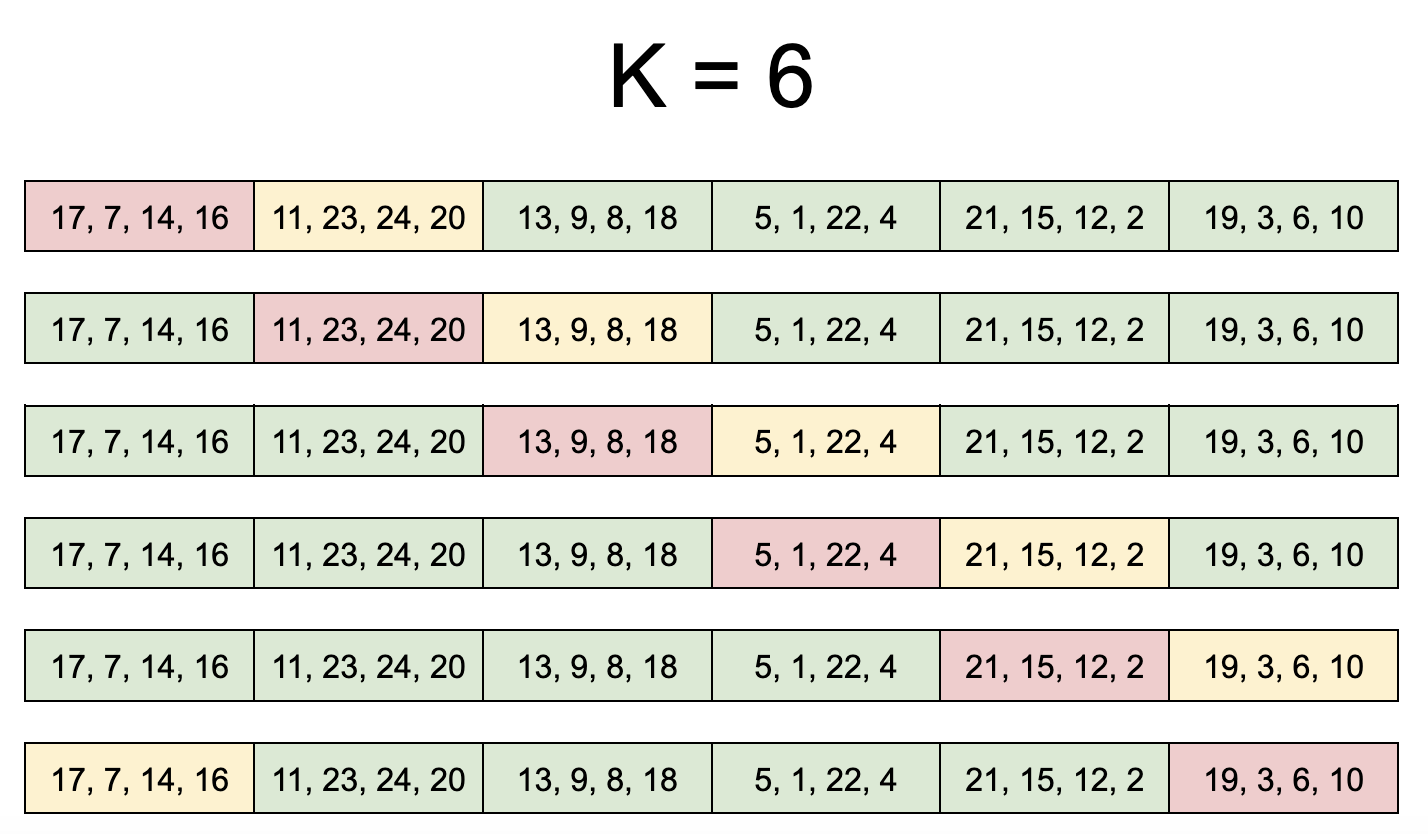

For our second method, we chose Support Vector Machine, which we will perform K-fold Cross Validation with Separate Validation on. The above image presents the train-validation-test splits for each fold. Green represents the training folds, Yellow represents the validation fold, and Red represents the test fold.

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [29]:
C_validation_values = [0.001, .005, 0.01, .05, 0.1, .5, 1, 5, 10, 50, 100, 500, 1000]

In [ ]:
for C_val in C_validation_values:
  print('C =', str(C_val))
  accuracies = []
  for fold_num in range(1,7):
    svm_model = SVC(kernel='rbf', C=C_val, gamma='scale')

    training_folds = set(chain(fold1, fold2, fold3, fold4, fold5, fold6)) # entire dataset, all 6 folds
    if (fold_num) == 6:
      globals()['fold'+str(fold_number)]
      training_folds.difference_update(globals()['fold'+str(fold_num)])
      training_folds.difference_update(fold1)
    else:
      training_folds.difference_update(globals()['fold'+str(fold_num)],globals()['fold'+str(fold_num+1)]) # drop the fold being used for testing

    train = audio_df[audio_df['actorID'].isin(training_folds)]
    x_train = train[feature_vars].copy()
    y_train = train[target_var].astype(int)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(x_train)

    svm_model.fit(X_train_scaled, y_train)

    if fold_num == 6:
      val = audio_df[audio_df['actorID'].isin(fold1)]
    else:
      val = audio_df[audio_df['actorID'].isin(globals()['fold'+str(fold_num+1)])]

    x_val = val[feature_vars].copy()
    X_val_scaled = scaler.transform(x_val)
    y_val = val[target_var].astype(int)

    y_pred = svm_model.predict(X_val_scaled)

    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")
  print('Average Accuracy:', np.mean(accuracies))

C = 0.001
Accuracy: 30.42%
Accuracy: 26.67%
Accuracy: 26.67%
Accuracy: 30.00%
Accuracy: 30.42%
Accuracy: 37.50%
Average Accuracy: 0.30277777777777776
C = 0.005
Accuracy: 30.42%
Accuracy: 26.67%
Accuracy: 26.67%
Accuracy: 30.00%
Accuracy: 30.42%
Accuracy: 37.50%
Average Accuracy: 0.30277777777777776
C = 0.01
Accuracy: 30.42%
Accuracy: 26.67%
Accuracy: 26.67%
Accuracy: 30.00%
Accuracy: 30.42%
Accuracy: 37.50%
Average Accuracy: 0.30277777777777776
C = 0.05
Accuracy: 31.25%
Accuracy: 27.08%
Accuracy: 27.50%
Accuracy: 30.00%
Accuracy: 30.42%
Accuracy: 37.92%
Average Accuracy: 0.3069444444444444
C = 0.1
Accuracy: 32.50%
Accuracy: 28.75%
Accuracy: 28.75%
Accuracy: 33.33%
Accuracy: 32.92%
Accuracy: 39.17%
Average Accuracy: 0.32569444444444445
C = 0.5
Accuracy: 35.42%
Accuracy: 30.83%
Accuracy: 33.33%
Accuracy: 37.50%
Accuracy: 36.25%
Accuracy: 39.58%
Average Accuracy: 0.3548611111111111
C = 1
Accuracy: 34.17%
Accuracy: 33.33%
Accuracy: 34.58%
Accuracy: 39.58%
Accuracy: 39.58%
Accuracy: 41.67%


We can see that C = 50 has the best accuracy accross the validation folds with an average of 38.75%, so we will proceed using this parameter and test on the test folds.

# (e) Comparative Analysis of Two Methods

Both models performed better than a random classifier, which would have about 12.5% accuracy.

In [33]:
LDA_confusion_matrices = []
LDA_accuracies = []
emotions = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

for fold_number in range(1,7):
  test_fold = globals()['fold'+str(fold_number)]
  test = audio_df[audio_df['actorID'].isin(test_fold)]
  y_test = test[target_var].astype(int)
  parameters = train_LDA(fold_number)
  y_pred = predict_LDA(parameters, fold_number)

  accuracy = test_LDA(fold_number)
  LDA_accuracies.append(accuracy)
  cm = confusion_matrix(y_test, y_pred)
  LDA_confusion_matrices.append(cm)

In [39]:
SVM_confusion_matrices = []
SVM_accuracies = []
emotions = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

for fold_num in range(1,7):
    svm_model = SVC(kernel='rbf', C=50, gamma='scale')

    training_folds = set(chain(fold1, fold2, fold3, fold4, fold5, fold6)) # entire dataset, all 6 folds
    training_folds.difference_update(globals()['fold'+str(fold_num)]) # drop the fold being used for testing

    train = audio_df[audio_df['actorID'].isin(training_folds)]
    x_train = train[feature_vars].copy()
    y_train = train[target_var].astype(int)

    # standardize the data on the training folds
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(x_train)

    svm_model.fit(X_train_scaled, y_train)

    test = audio_df[audio_df['actorID'].isin(globals()['fold'+str(fold_num)])]

    # using the same standardization on the test fold
    x_test = test[feature_vars].copy()
    X_test_scaled = scaler.transform(x_test)
    y_test = test[target_var].astype(int)

    y_pred = svm_model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    SVM_accuracies.append(accuracy)
    cm = confusion_matrix(y_test, y_pred)
    SVM_confusion_matrices.append(cm)

In [38]:
for LDA_accuracy in LDA_accuracies:
  print(f"Accuracy: {LDA_accuracy * 100:.2f}%")
print('Average Accuracy:', np.mean(LDA_accuracies) * 100,'%')

Accuracy: 43.75%
Accuracy: 30.00%
Accuracy: 28.75%
Accuracy: 34.58%
Accuracy: 33.75%
Accuracy: 42.08%
Average Accuracy: 35.48611111111111 %


In [40]:
for SVM_accuracy in SVM_accuracies:
  print(f"Accuracy: {SVM_accuracy * 100:.2f}%")
print('Average Accuracy:', np.mean(SVM_accuracies) * 100,'%')

Accuracy: 45.42%
Accuracy: 35.00%
Accuracy: 38.75%
Accuracy: 32.50%
Accuracy: 44.17%
Accuracy: 39.58%
Average Accuracy: 39.23611111111111 %


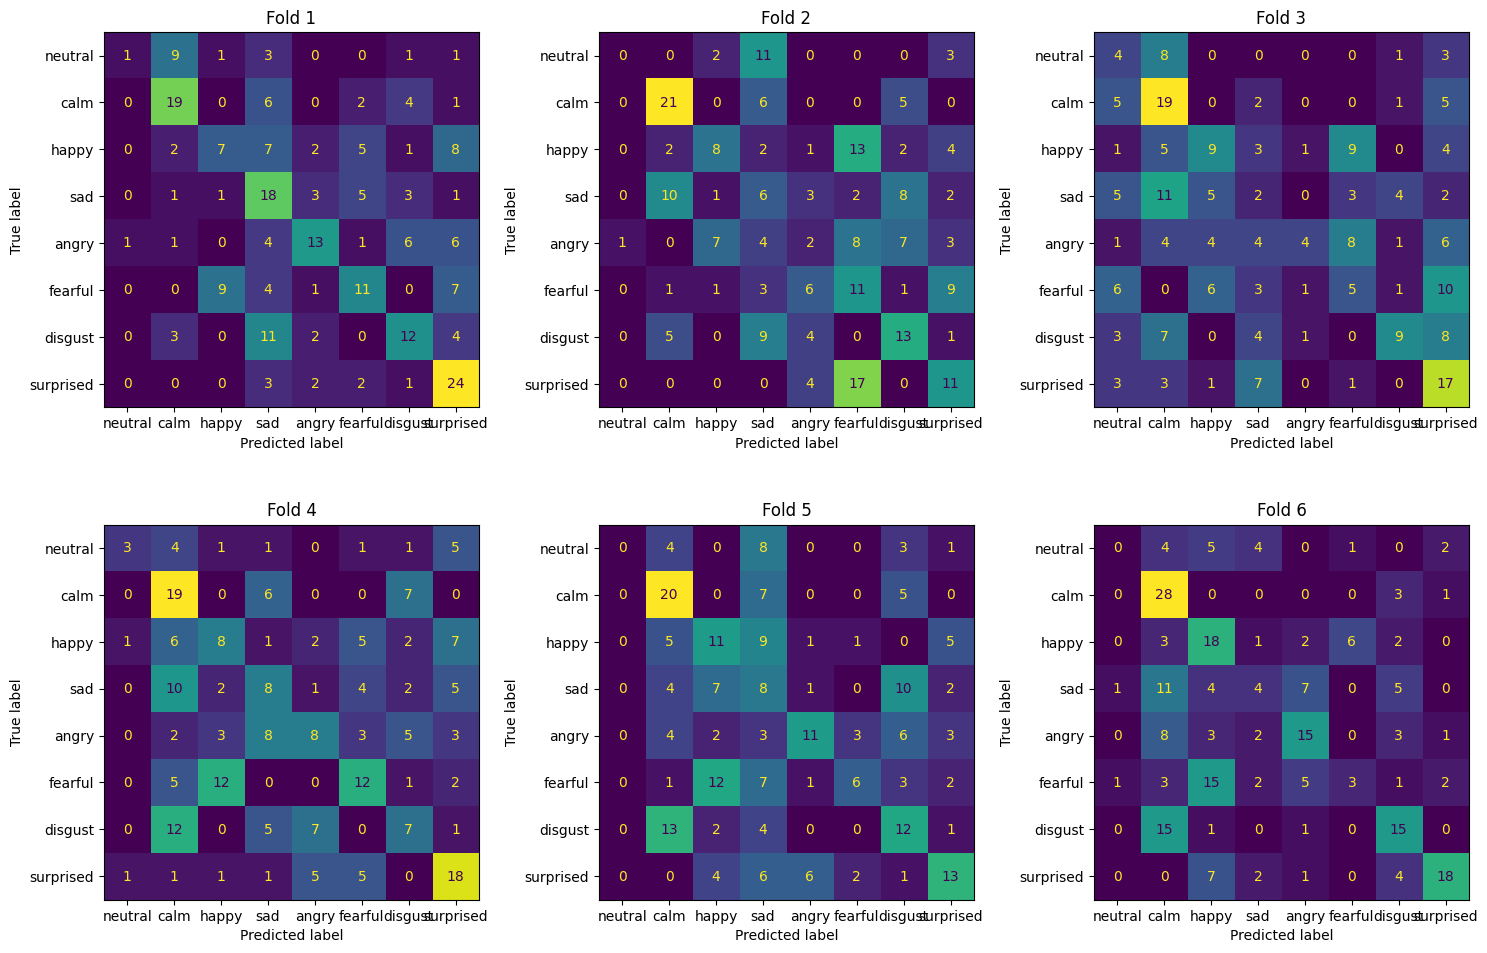

In [41]:
# LDA confusion matrices
# Plot all confusion matrices in a grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 folds
axes = axes.flatten()  # Flatten axes for easier iteration

for i, cm in enumerate(LDA_confusion_matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
    disp.plot(cmap="viridis", ax=axes[i], colorbar=False)  # Use a consistent colormap
    axes[i].set_title(f"Fold {i+1}")  # Add titles to each subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

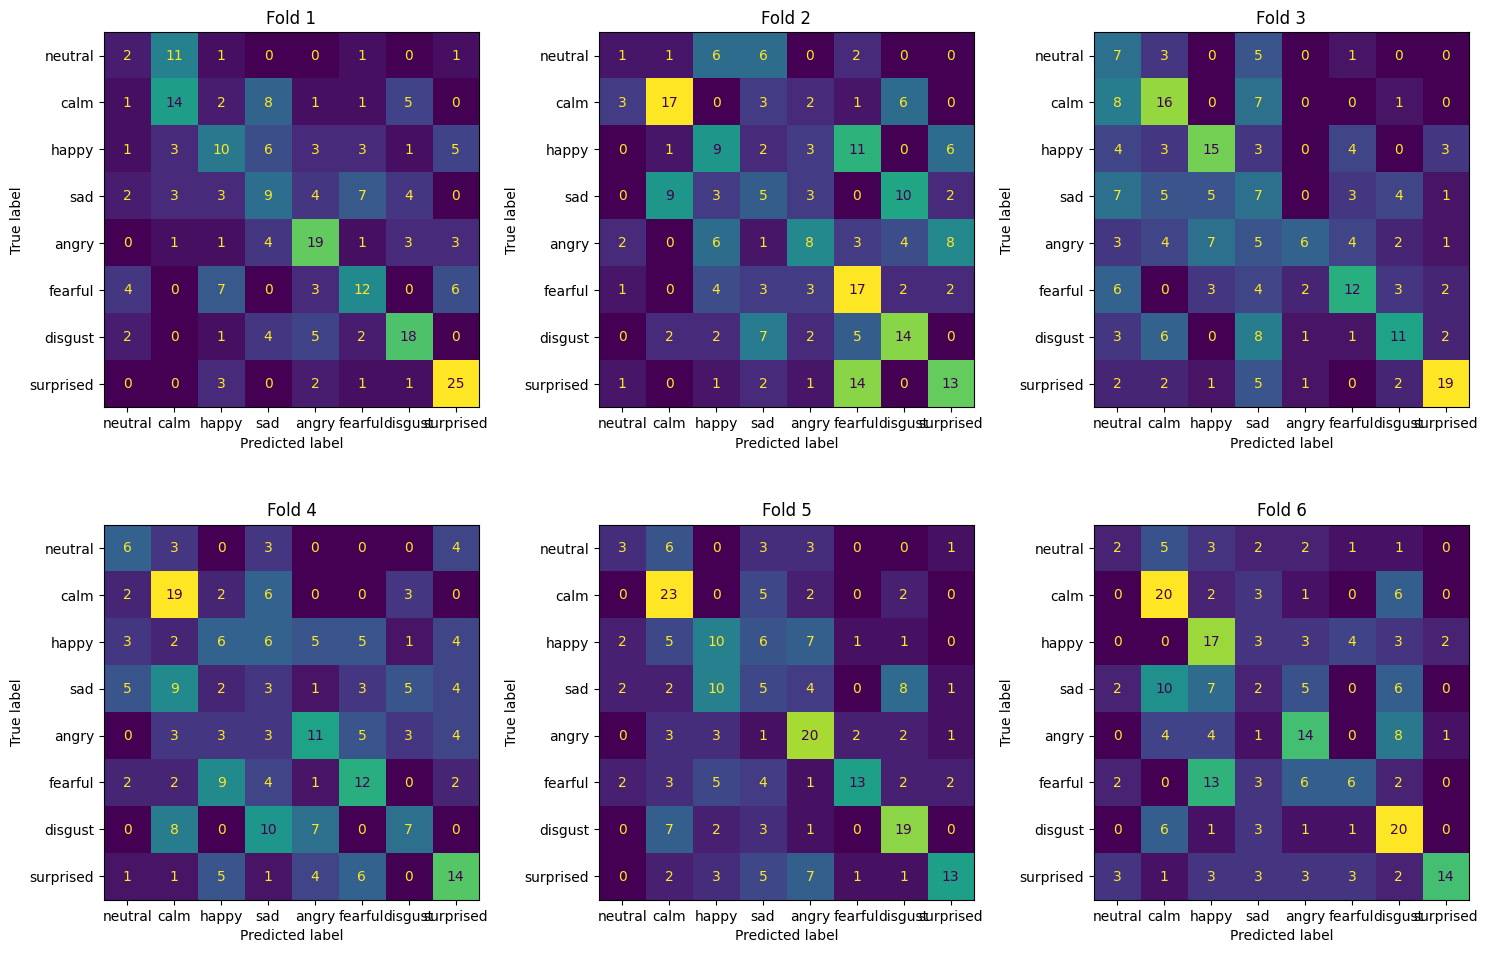

In [42]:
# SVM confusion matrices
# Plot all confusion matrices in a grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 folds
axes = axes.flatten()  # Flatten axes for easier iteration

for i, cm in enumerate(SVM_confusion_matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
    disp.plot(cmap="viridis", ax=axes[i], colorbar=False)  # Use a consistent colormap
    axes[i].set_title(f"Fold {i+1}")  # Add titles to each subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Support Vector Machine has a lot more computational complexity, but it performs better than Linear Discriminant Analysis. However, the change in accuracy is not that steep, which means even a simpler model such as LDA can yield competitive results. Despite this, SVM is able to detect more emotions correctly.

LDA did best at accurately classifying ‘calm’ and ‘surprised’ samples, but often classifies ‘disgust’ as ‘calm’, and ‘fearful’ as ‘happy’.

SVM did well at accurately classifying all emotions, except ‘neutral’, ‘sad’, which were in general not the predicted label accross all samples. It often classifies ‘disgust’ as ‘sad’.


For these reasons, we would recommend that the Support Vector Machine model goes into production since we are dealing with a small training dataset, and we can handle that amount of computational complexity.

# (f) Discussion on Ethical Issues

A top ethical concern is gathering audio data for this model to classify. If we record people without their consent, there are privacy issues that come with that, while these people may not even know their data is floating around.

Another issue is that this dataset is not that inclusive. It doesn't include child actors, transgender actors, or people with non-American accents. These demographics would be excluded out of the benefits of this model.

# (g) Bibliography

[1] Choi Y, Lee S, Jung S, Choi IM, Park YK, and Kim C Development of an auditory emotion recognition function using psychoacoustic parameters based on the international affective digitized sounds Behavior Research Methods 2015 47 4 1076-1084

[2] El Ayadi, M., Kamel, M. S., & Karray, F. (2011). Survey on speech emotion recognition: Features, classification schemes, and databases. Pattern Recognition, 44, 572–587. doi:10.1016/j.patcog.2010.09.020

[3*] Golembeski, C. (n.d.). Bit depth and sample rate explained. Status Audio. https://www.status.co/blogs/the-journal/bit-depth-and-sample-rate-explained#:~:text=Sample%20rate%20is%20the%20resolution,within%20each%20sample%20of%20audio

[4*] Hudson AI, Holbrook A. A study of the reading fundamental vocal frequency of young black adults. J Speech Hear Res. 1981 Jun;24(2):197-200. doi: 10.1044/jshr.2402.197. PMID: 7265934.

[5*] Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

# (h) extra code

In [ ]:
# Trim silence
    #processed, _ = librosa.effects.trim(y, top_db=20)

    # Normalize the waveform
    #processed = librosa.util.normalize(processed)

    # Optional: Plot the waveform
    '''
    plt.figure(figsize=(12, 4))
    plt.plot(time_stamps, intensity_values, label="Processed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Processed Audio Waveform (Normalized to [-1, 1])")
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(time_stamps, normalized_values, label="Processed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Processed Audio Waveform (Normalized to [-1, 1])")
    plt.grid()
    plt.legend()
    plt.show()
    '''
    #return processed

3.3032916666666665
1.208
1.230657596371882


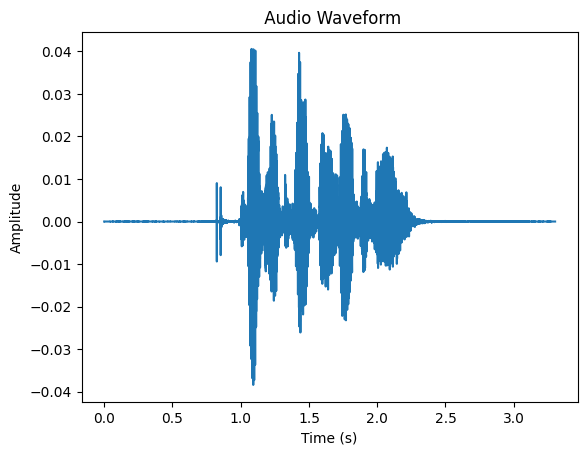

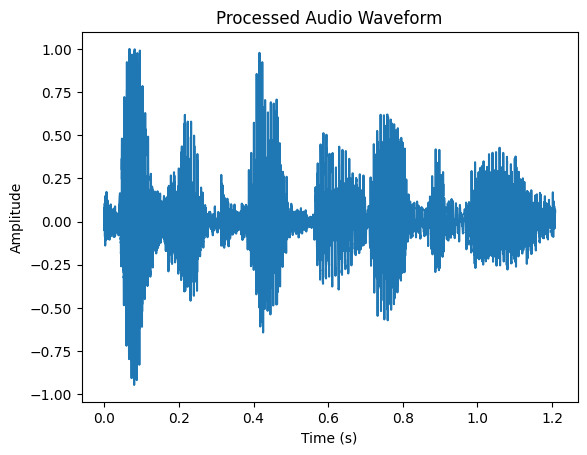

In [ ]:
path = '/content/drive/MyDrive/ML_F24_Team_Project/Dataset1/Audio_Dataset/Actor_01/03-01-01-01-01-01-01.wav'
snd = parselmouth.Sound(path)
print(snd.duration)

sndnew = preprocess_audio(path)
print(sndnew.duration)

y, sr = librosa.load(path)
ynew, _ = librosa.effects.trim(y, top_db=20)
print(librosa.get_duration(y=ynew,sr=sr))

plt.plot(snd.xs(), snd.values.T)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(' Audio Waveform')
plt.show()

plt.plot(sndnew.xs(), sndnew.values.T)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Processed Audio Waveform')
plt.show()

In [ ]:
#fund_freq = []

folders = []
for i in range(9,10):
  directory_path = '/content/drive/MyDrive/ML_F24_Team_Project/Dataset1/Audio_Dataset/Actor_0'+str(i)
  folders.append(directory_path)

for folder in folders:
  for file_name in os.listdir(folder):
    path = os.path.join(folder, file_name)
    processed = preprocess_audio(path)
    '''
    f0, voiced_flag, voiced_probs = librosa.pyin(
            processed,
            fmin=librosa.note_to_hz('C2'),  # Minimum pitch (65.41 Hz)
            fmax=librosa.note_to_hz('C7'),  # Maximum pitch (2093 Hz)
            sr=sr
        )
    if np.isnan(np.nanmean(f0)):
      snd = parselmouth.Sound(path)
      pitch = snd.to_pitch()
      pitch_values = pitch.selected_array['frequency']
    else:
      print(file_name,':',np.nanmean(f0))
  '''
# Extract pitch
    pitch = processed.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    print(np.nanmean(pitch_values))
'''
    # Plot
    plt.plot(pitch.xs(), pitch_values)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Fundamental Frequency (Praat)')
    plt.show()
'''
#audio_df['pitch'] = fund_freq

214.4678296886536
198.08525168100712
73.2965127701086
81.50074896361369
91.86506305982924
180.76409346722457
42.64965584638382
99.64696472829247
81.46232595640531
59.87940242416651
110.04456183934487
86.74536416860548
46.453771914351066
174.54605248764213
200.5304331055903
70.43495829189717
256.77090150561816
66.40989521633115
104.7203819922565
87.66923210153307
109.07056553868763
79.01210898315831
55.58153086292498
43.84774452630991
122.85705298776202
78.4703944921275
64.72757411399728
75.9810909333853
76.10058866906706
76.07432136035511
67.6896488055169
75.39874398853927
111.53362573944167
28.24556094699112
96.29115844305744
68.86572939692856
48.99793138754587
162.08316521437018
159.9452086237126
75.67806156413769
69.24785449938278
133.06163775890212
60.62138021562811
84.34231914699845
99.91147719690024
58.72537860611171
65.80611993662117
73.0262112740264
88.5591422232754
63.848664208247776
80.87570712733317
99.43430214304038
73.28980679790304
77.5590207194947
148.49734046934438
74.6

"\n    # Plot\n    plt.plot(pitch.xs(), pitch_values)\n    plt.xlabel('Time (s)')\n    plt.ylabel('Frequency (Hz)')\n    plt.title('Fundamental Frequency (Praat)')\n    plt.show()\n"

try at least a good amount for hyperparameters, like 10-15

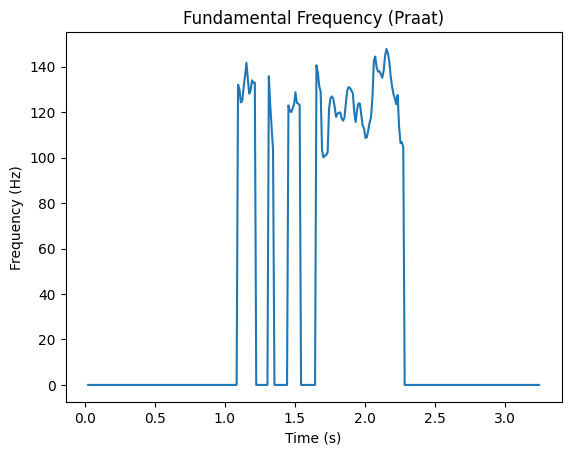

F0 Statistics:
  Mean F0: 34.38 Hz
  Median F0: 0.00 Hz
  Min F0: 0.00 Hz
  Max F0: 147.86 Hz


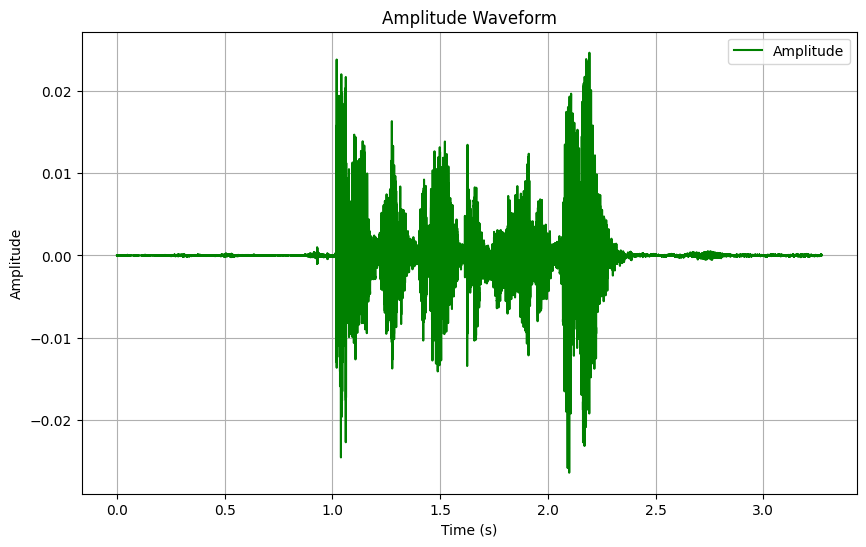

<ipython-input-87-18b5143c5543>:47: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y), ref=np.max), sr=sr, x_axis='time', y_axis='hz')


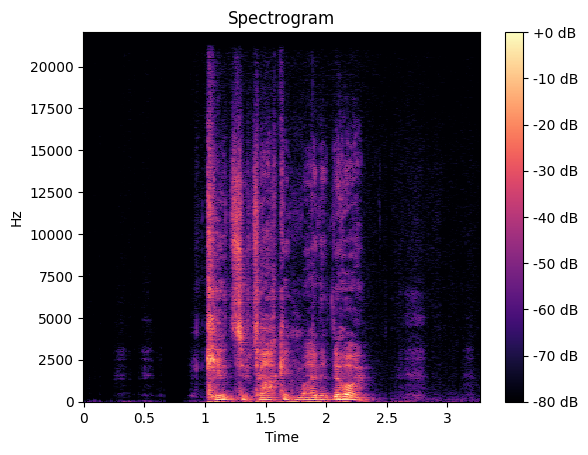

'\ny = preprocess_audio(path)\n\ntimes = np.linspace(0, len(y) / sr, num=len(y))\n\n# Plot the amplitude waveform\nplt.figure(figsize=(10, 6))\nplt.plot(times, y, label=\'Amplitude\', color=\'green\')\nplt.xlabel(\'Time (s)\')\nplt.ylabel(\'Amplitude\')\nplt.title(\'Amplitude Waveform\')\nplt.legend()\nplt.grid()\nplt.show()\n\n    # Extract F0 using librosa.pyin\nf0, voiced_flag, voiced_probs = librosa.pyin(\n        y,\n        fmin=1,  # Minimum pitch (65.41 Hz)\n        fmax=11000,  # Maximum pitch (2093 Hz)\n        sr=sr\n)\n\n    # Generate a time axis for the F0 values\ntimes = librosa.times_like(f0, sr=sr)\n\n    # Plot the F0 values\nplt.figure(figsize=(10, 6))\nplt.plot(times, f0, label=\'Fundamental Frequency (F0)\', color=\'blue\')\nplt.xlabel(\'Time (s)\')\nplt.ylabel(\'Frequency (Hz)\')\nplt.title(\'Fundamental Frequency (F0) Over Time\')\nplt.legend()\nplt.grid()\nplt.show()\n\n    # Print statistics for F0\nprint("F0 Statistics:")\nprint(f"  Mean F0: {np.nanmean(f0):.2

In [ ]:
path = '/content/drive/MyDrive/ML_F24_Team_Project/Dataset1/Audio_Dataset/Actor_09/03-01-06-02-01-02-09.wav'


# Load the audio file
y, sr = librosa.load(path, sr=sr)

times = np.linspace(0, len(y) / sr, num=len(y))

snd = parselmouth.Sound(path)

# Extract pitch
pitch = snd.to_pitch()
pitch_values = pitch.selected_array['frequency']

# Plot
plt.plot(pitch.xs(), pitch_values)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fundamental Frequency (Praat)')
plt.show()

    # Print statistics for F0
print("F0 Statistics:")
print(f"  Mean F0: {np.nanmean(pitch_values):.2f} Hz")
print(f"  Median F0: {np.nanmedian(pitch_values):.2f} Hz")
print(f"  Min F0: {np.nanmin(pitch_values):.2f} Hz")
print(f"  Max F0: {np.nanmax(pitch_values):.2f} Hz")



# Plot the amplitude waveform
plt.figure(figsize=(10, 6))
plt.plot(times, y, label='Amplitude', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude Waveform')
plt.legend()
plt.grid()
plt.show()

librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y), ref=np.max), sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()





y = preprocess_audio(path)

snd = parselmouth.Sound(path)

# Extract pitch
pitch = snd.to_pitch()
pitch_values = pitch.selected_array['frequency']

# Plot
plt.plot(pitch.xs(), pitch_values)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fundamental Frequency (Praat)')
plt.show()

    # Print statistics for F0
print("F0 Statistics:")
print(f"  Mean F0: {np.nanmean(pitch_values):.2f} Hz")
print(f"  Median F0: {np.nanmedian(pitch_values):.2f} Hz")
print(f"  Min F0: {np.nanmin(pitch_values):.2f} Hz")
print(f"  Max F0: {np.nanmax(pitch_values):.2f} Hz")

times = np.linspace(0, len(y) / sr, num=len(y))

# Plot the amplitude waveform
plt.figure(figsize=(10, 6))
plt.plot(times, y, label='Amplitude', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude Waveform')
plt.legend()
plt.grid()
plt.show()

    # Extract F0 using librosa.pyin
f0, voiced_flag, voiced_probs = librosa.pyin(
        y,
        fmin=1,  # Minimum pitch (65.41 Hz)
        fmax=11000,  # Maximum pitch (2093 Hz)
        sr=sr
)

    # Generate a time axis for the F0 values
times = librosa.times_like(f0, sr=sr)

    # Plot the F0 values
plt.figure(figsize=(10, 6))
plt.plot(times, f0, label='Fundamental Frequency (F0)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Fundamental Frequency (F0) Over Time')
plt.legend()
plt.grid()
plt.show()

    # Print statistics for F0
print("F0 Statistics:")
print(f"  Mean F0: {np.nanmean(f0):.2f} Hz")
print(f"  Median F0: {np.nanmedian(f0):.2f} Hz")
print(f"  Min F0: {np.nanmin(f0):.2f} Hz")
print(f"  Max F0: {np.nanmax(f0):.2f} Hz")
'''

In [ ]:
fold_number = 4
test_fold = globals()['fold'+str(fold_number)]
training_folds = set(chain(fold1, fold2, fold3, fold4, fold5, fold6)) # entire dataset, all 6 folds
training_folds.difference_update(test_fold) # drop the fold being used for testing
print(training_folds)
print(test_fold)

feature_vars = ['pitch','timing','loudness','fluctuation']
target_var = 'emotion'

train = audio_df[audio_df['actorID'].isin(folds)]
x_train = train[feature_vars].copy()
y_train = train[target_var].astype(int)

test = audio_df[audio_df['actorID'].isin(fold4)]
x_test = test[feature_vars].copy()
y_test = test[target_var].astype(int)

{2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24}
[5, 1, 22, 4]


In [ ]:
def train_LDA (fold_number):
  test_fold = globals()['fold'+str(fold_number)]

  training_folds = set(chain(fold1, fold2, fold3, fold4, fold5, fold6)) # entire dataset, all 6 folds
  training_folds.difference_update(test_fold) # drop the fold being used for testing


  train = audio_df[audio_df['actorID'].isin(training_folds)]
  x_train = train[feature_vars].copy()
  y_train = train[target_var].astype(int)

  # LDA
  parameters = LinearDiscriminantAnalysis()
  parameters.fit(x_train, y_train)
  print(parameters.means_)

  return parameters

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_train.dtypes)
print(y_test.dtypes)

(0, 4)
(0,)
(240, 4)
(240,)
pitch          float64
timing         float64
loudness       float64
fluctuation    float64
dtype: object
int64
